In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.signal import detrend
from matplotlib import pyplot as plt
from scipy import signal

#%matplotlib inline

import xarray as xr
import intake
import pprint 

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col;

In [3]:
# future scenarios
cat = col.search(activity_id = 'ScenarioMIP', variable_id='ts', source_id='CESM2',table_id='Amon', member_id = 'r1i1p1f1')
scenario_dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
scenario_dset_dict.keys()
ssp_keys = []
for key in scenario_dset_dict.keys():
    ssp_keys.append(key)
ssp_keys

# historical
cat = col.search(experiment_id = 'historical', variable_id='ts', source_id='CESM2',table_id='Amon', member_id = 'r1i1p1f1')
cat.df
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
dset_dict.keys()
ds = dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn']


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)

xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


## Functions for computing areaweigths:

In [4]:
def cos_weights(lat):
    weights = np.cos(np.deg2rad(lat))
    weights /= weights.mean()
    return weights

def area_weights(lat_bnds, lon_bnds): # computes exact areas assuming earth is a perfect sphere
    lowerlats = np.radians(lat_bnds[:,0]); upperlats = np.radians(lat_bnds[:,1])
    difflon = np.radians(np.diff(lon_bnds[0,:])) # if the differences in longitudes are all the same
    areaweights = difflon*(np.sin(upperlats) - np.sin(lowerlats));
    areaweights /= areaweights.mean()
    return areaweights # list of weights, of same dimension as latitude

## Compute global mean values, and concatenate historical with scenarios:

In [5]:
ts_anom = {}
ts_glmean = {}

for i in range(len(ssp_keys)):
    exp_id = ssp_keys[i][-14:-8]
    ssp_ds = scenario_dset_dict[ssp_keys[i]]
    all_ds = xr.concat([ds, ssp_ds], dim = 'time');
    ts_clim = all_ds.ts.groupby('time.month').mean(dim='time')
    ts_anom[exp_id] = all_ds.ts.groupby('time.month') - ts_clim
    ts_glmean[exp_id] = (ts_anom[exp_id] * area_weights(ssp_ds['lat_bnds'], ssp_ds['lon_bnds'])).mean(dim=['lon', 'lat'])
    ts_glmean[exp_id] = ts_glmean[exp_id] - ts_glmean[exp_id].isel(time = 0)
    

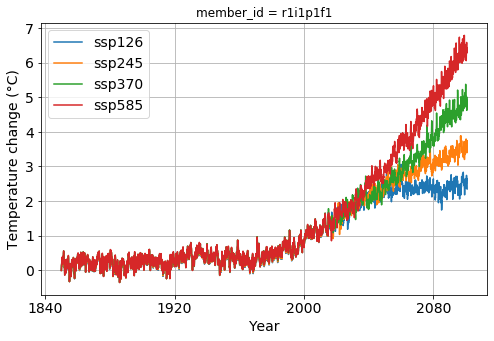

In [6]:
fig, axes = plt.subplots(figsize = (8,5))

for i in range(len(ssp_keys)):
    exp_id = ssp_keys[i][-14:-8]
    ts_glmean[exp_id].plot(ax = axes, label = exp_id)
    
plt.grid()
plt.legend(loc = 'upper left', fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Temperature change (°C)', fontsize = 14);

## Compute average anomaly over Nino3.4 region

In [7]:
ts_nino34 = {}
nino34_index = {}

for i in range(len(ssp_keys)):
    exp_id = ssp_keys[i][-14:-8]
    ssp_ds = scenario_dset_dict[ssp_keys[i]]
    weights = area_weights(ssp_ds['lat_bnds'], ssp_ds['lon_bnds']).sel(lat=slice(-5, 5))
    
    ts_nino34[exp_id]= (ts_anom[exp_id].sel(lat=slice(-5, 5), lon=slice(190, 240)) * weights).mean(dim=['lon', 'lat'])
    ts_nino34[exp_id] = ts_nino34[exp_id] - ts_nino34[exp_id].isel(time = 0)
    nino34_index[exp_id] = ts_nino34[exp_id].rolling(time=3, center=True).mean().dropna('time')

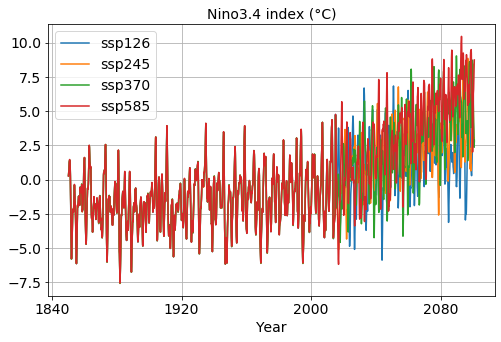

In [8]:
fig, axes = plt.subplots(figsize = (8,5))

for i in range(len(ssp_keys)):
    exp_id = ssp_keys[i][-14:-8]
    nino34_index[exp_id].plot(ax = axes, label = exp_id)
    
plt.grid()
plt.legend(loc = 'upper left', fontsize = 14)
plt.tick_params(axis='both', labelsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.title('Nino3.4 index (°C)', fontsize = 14);

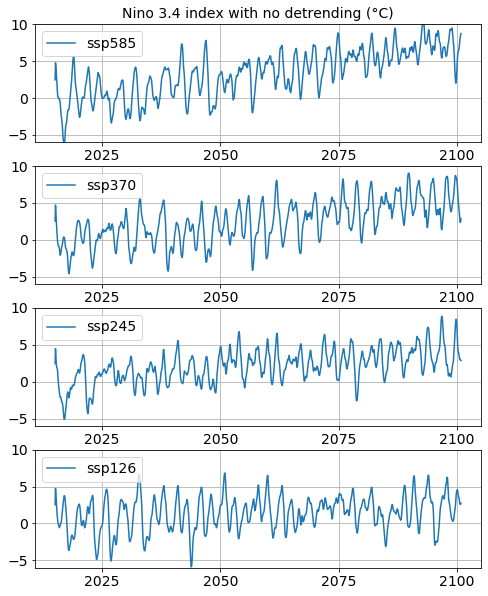

In [11]:
fig, axes = plt.subplots(nrows=4, figsize = (8,10))

for i in range(len(ssp_keys)):
    exp_id = ssp_keys[len(ssp_keys)-i-1][-14:-8]
    times = nino34_index[exp_id]['time'].sel(time=slice('2015', '2100'))
    data = nino34_index[exp_id].isel(member_id=0).sel(time=slice('2015', '2100'))
    axes[i].plot(times, data, label = exp_id)
    axes[i].grid()
    axes[i].tick_params(axis='both', labelsize = 14)
    axes[i].legend(loc = 'upper left', fontsize = 14)
    axes[i].set_ylim(-6,10)
    if i == 0:
        axes[i].set_title('Nino 3.4 index with no detrending (°C)', fontsize = 14);
    elif i==len(ssp_keys):
        axes[i].set_xlabel('Year', fontsize = 14)


## Nino 3.4 index with detrending

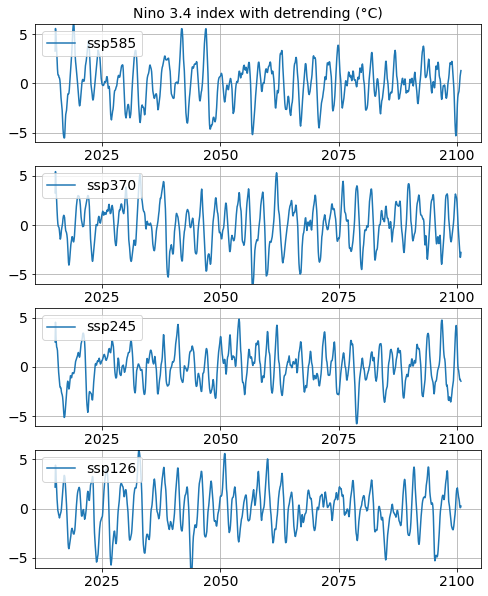

In [15]:
fig, axes = plt.subplots(nrows=4, figsize = (8,10))

for i in range(len(ssp_keys)):
    exp_id = ssp_keys[len(ssp_keys)-i-1][-14:-8]
    times = nino34_index[exp_id]['time'].sel(time=slice('2015', '2100'))
    data = nino34_index[exp_id].isel(member_id=0).sel(time=slice('2015', '2100'))
    detrended_data = xr.apply_ufunc(detrend, data, kwargs={'axis': 0}, dask = 'allowed')
    axes[i].plot(times, detrended_data, label = exp_id)
    axes[i].grid()
    axes[i].tick_params(axis='both', labelsize = 14)
    axes[i].legend(loc = 'upper left', fontsize = 14)
    axes[i].set_ylim(-6,6)
    if i == 0:
        axes[i].set_title('Nino 3.4 index with detrending (°C)', fontsize = 14);
    elif i==len(ssp_keys):
        axes[i].set_xlabel('Year', fontsize = 14)